In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io

import os, re

import claude.utils as cu
import claude.claudeflow.autoencoder as ae
import claude.claudeflow.helper as cfh
import claude.claudeflow.models.NLIN as cfnlin

In [2]:
seed = 42
tf.set_random_seed(seed)
np.random.seed(seed)

# Parameters
# Channel Parameters
chParam = cu.AttrDict()
chParam.M		  = 64
chParam.D		  = 16.4640
chParam.PolMux	  = 1
chParam.PdBm	  = 1
chParam.Nspan	  = 20
chParam.ChSpacing = np.array([-100., -50., 50., 100.])

# Auto-Encoder Parameters
aeParam = cu.AttrDict()
aeParam.dimension	= 2
aeParam.nLayers		= 2
aeParam.hiddenUnits	= 32
aeParam.activation  = tf.nn.selu
aeParam.dropout		= False
aeParam.dtype       = tf.float32
aeParam.GN	        = False
aeParam.optimizeP   = True

# Training Parameters
trainingParam = cu.AttrDict()
trainingParam.sampleSize	= 128*chParam.M
trainingParam.batchSize 	= 16*chParam.M  # Increase for better results (especially if M>16)
trainingParam.learningRate	= 0.001
trainingParam.displayStep	= 50
trainingParam.path			= 'results'
trainingParam.filename		= 'P{}_M{}_nSpans{}'.format(chParam.PdBm,chParam.M,chParam.Nspan)
trainingParam.saveWeights	= False
trainingParam.earlyStopping = 250
trainingParam.iterations    = 250
trainingParam.summaries     = True
trainingParam.endWithLargeBatch = True

# create string identifier for tensorboard
if trainingParam.summaries:
    chHyperParam = ['M','PdBm','Nspan']
    aeHyperParam = ['GN']
    trainingHyperParam = ['sampleSize','batchSize','learningRate']	

    trainingParam.summaryString = ','.join(  [ '{}={}'.format(item,chParam[item]) for item in chHyperParam ]
                                            +[ '{}={}'.format(item,trainingParam[item]) for item in trainingHyperParam ]
                                            +[ '{}={}'.format(item,aeParam[item]) for item in aeHyperParam ] )

# TF constants
two = tf.constant(2,aeParam.dtype)

In [3]:
from claude.models.NLIN import defaultParameters,\
                               calcAseNoisePower,\
                               calcIntraConstants,calcInterConstants,\
                               calcIntraChannelNLIN,calcInterChannelNLIN,\
                               calcIntraChannelGN,calcInterChannelGN

In [4]:
# NLIN model
p = defaultParameters( D=chParam.D )
p.PdBm = chParam.PdBm
p.Nspan = chParam.Nspan
p.PolMux = chParam.PolMux

# Calculate System constants
nChannels = chParam.ChSpacing.size
interConst = np.zeros( (2,nChannels) )
for ii,channel in enumerate(chParam.ChSpacing):
    p.ChSpacing = channel
    interConst[:,ii] = calcInterConstants(p)
intraConst = calcIntraConstants(p)
aseNoisePower = calcAseNoisePower(p)

# Model constants to tensorflow
intra_const = tf.expand_dims( tf.constant( intraConst, aeParam.dtype), axis=1)
inter_const = tf.constant( interConst, aeParam.dtype)

# learn optimal power or not
if aeParam.optimizeP:
    P0 = cu.dB2lin( chParam.PdBm, 'dBm')
    P0 = tf.constant(P0,aeParam.dtype)
    P0 = tf.contrib.distributions.softplus_inverse( P0 )
    P0 = tf.nn.softplus(tf.Variable( P0 ))    
else:
    P0 = tf.constant( cu.dB2lin( chParam.PdBm, 'dBm'), aeParam.dtype )
    
PdBm = cfh.lin2dB(P0, 'dBm')

In [5]:
# Tensorflow input
X = tf.placeholder( aeParam.dtype, shape=(None, chParam.M) )

# keep_prob = tf.placeholder(aeParam.dtype)

sigma2_noise = tf.constant( aseNoisePower, aeParam.dtype)

# enc_seed will hold the most recent constellation points
X_seed = tf.constant(np.eye(chParam.M),aeParam.dtype)
enc_seed       = ae.encoder(X_seed,aeParam.hiddenUnits,aeParam.nLayers,aeParam.activation,nOutput=aeParam.dimension,summaries=True)
enc_seed_norm  = cfh.IQ_norm(enc_seed)
enc_seed_power = tf.sqrt( P0 ) * enc_seed_norm

In [6]:
# NLIN or GN model
if aeParam.GN:
    sigma2_inter = cfnlin.calcInterChannelGN(inter_const,P0,chParam.PolMux,dtype=aeParam.dtype)
    sigma2_intra = cfnlin.calcIntraChannelGN(intra_const,P0,chParam.PolMux,dtype=aeParam.dtype)
else:
    # kur = mean(abs(const).^4)/mean(abs(const).^2).^2; % Second order modulation factor <|a|^4>/<|a|^2>^2
    # kur3 = mean(abs(const).^6)/mean(abs(const).^2).^3; % Third order modulation factor <|a|^6>/<|a|^2>^3
    constellation_abs = cfh.IQ_abs(enc_seed_power)
    kur  = tf.reduce_mean(tf.pow(constellation_abs,4))/tf.pow(P0,2)
    kur3 = tf.reduce_mean(tf.pow(constellation_abs,6))/tf.pow(P0,3)
    sigma2_inter = cfnlin.calcInterChannelNLIN(inter_const,kur,P0,chParam.PolMux,dtype=aeParam.dtype)
    sigma2_intra = cfnlin.calcIntraChannelNLIN(intra_const,kur,kur3,P0,chParam.PolMux,dtype=aeParam.dtype)

sigma2_nlin = tf.reduce_sum( sigma2_intra ) + tf.reduce_sum( sigma2_inter )

In [7]:
# Auto-encoder
enc = ae.encoder(X,aeParam.hiddenUnits,aeParam.nLayers,aeParam.activation,nOutput=aeParam.dimension)
enc_norm = cfh.IQ_norm( enc )
enc_power = tf.sqrt( P0 ) * enc_norm

sigma2 = sigma2_noise + sigma2_nlin
noise = tf.sqrt( sigma2 )\
            *tf.rsqrt(two)\
            *tf.random_normal(shape=tf.shape(enc_power),dtype=aeParam.dtype)

channel = enc_power + noise
channel_norm = channel * tf.rsqrt( P0 )

decoder = ae.decoder(channel_norm,aeParam.hiddenUnits,aeParam.nLayers,aeParam.activation,chParam.M,summaries=True)
softmax = tf.nn.softmax(decoder)

In [8]:
# Metrics, Loss etc
correct_prediction = tf.equal(tf.argmax(X,1), tf.argmax(decoder,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, aeParam.dtype))

# softmax = P(x|y)
Px = tf.constant( 1/chParam.M, aeParam.dtype )
MI = cfh.MI(softmax, X, Px)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=X,logits=decoder))
optimizer = tf.train.AdamOptimizer(learning_rate=trainingParam.learningRate).minimize(loss)

# avg_metric_reset: set to zero
# avg_metric_update: add recent value to variable
# avg_metric: get average of sum'd variables
avg_accuracy, avg_accuracy_update, avg_accuracy_reset = cfh.create_reset_metric(tf.metrics.mean, 'accuracy_metric', accuracy)
avg_xentropy, avg_xentropy_update, avg_xentropy_reset = cfh.create_reset_metric(tf.metrics.mean, 'xentropy_metric', loss)
avg_MI, avg_MI_update, avg_MI_reset = cfh.create_reset_metric(tf.metrics.mean, 'MI_metric', MI)
reset_ops = [avg_accuracy_reset, avg_xentropy_reset, avg_MI_reset]
update_ops = [avg_accuracy_update, avg_xentropy_update, avg_MI_update]

In [9]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# summaries for tensorboard
if trainingParam.summaries:
    # Summaries
    s = [tf.summary.scalar('accuracy', avg_accuracy),
         tf.summary.scalar('xentropy', avg_xentropy),
         tf.summary.scalar('MI', avg_MI),
         tf.summary.scalar('Plin', P0),
         tf.summary.scalar('PdBm', PdBm),
         tf.summary.scalar('sigma2_noise', sigma2_noise),
         tf.summary.scalar('sigma2_nlin', sigma2_nlin)]

    if not aeParam.GN:
        s.extend( [tf.summary.scalar('kur', kur),
                   tf.summary.scalar('kur3', kur3)] )

    summaries = tf.summary.merge_all()

    summaries_dir = os.path.join(trainingParam.path,'tboard',trainingParam.summaryString)
    os.makedirs(summaries_dir, exist_ok=True)

    train_writer = tf.summary.FileWriter(summaries_dir + '/train', sess.graph)
else:
    train_writer = None

# save process
saver = tf.train.Saver()
checkpoint_path = os.path.join(trainingParam.path,'checkpoint',trainingParam.filename,'best')
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
else:
    pass
    #print("Restoring checkpoint...", flush=True)
    #saver.restore(sess=sess,save_path=checkpoint_path)

# early stopping and keeping the best result
bestLoss = 100000
bestAcc = 0
lastImprovement = 0

nBatches = int(trainingParam.sampleSize/trainingParam.batchSize)

In [10]:
# training
for epoche in range(1, trainingParam.iterations+1):
    # end with larger batchsize
    if trainingParam.endWithLargeBatch and epoche > 0.75 * trainingParam.iterations:
        batchSize = trainingParam.sampleSize
    else:        
        batchSize = trainingParam.batchSize
        
    sess.run(reset_ops)
    
    for batch in range(0,nBatches):
        x, _, xSeed = cu.hotOnes(batchSize,(1,0),chParam.M,seed=batch)
        
        feedDict = { X: x }
        sess.run([optimizer, update_ops], feed_dict=feedDict)
    
    [outPdBm, outSigma2Nlin, outSigma2, latestConstellation] = sess.run([PdBm, sigma2_nlin, sigma2, enc_seed_norm], feed_dict=feedDict)
    [avLoss, avAccuracy, avMI] = sess.run([avg_xentropy, avg_accuracy, avg_MI])
    
    if trainingParam.summaries:
        outSummaries = sess.run(summaries, feed_dict=feedDict)
        train_writer.add_summary(outSummaries,epoche)

    if avLoss < bestLoss:
        bestLoss = avLoss
        bestAcc = avAccuracy
        lastImprovement = epoche
        saver.save(sess=sess,save_path=checkpoint_path)

    if epoche - lastImprovement > trainingParam.earlyStopping:
        print("Breaking due to no improvement")
        break;        

    if epoche%trainingParam.displayStep == 0:
        print('epoche: {} - avDecLoss: {:.2f} - avAccuracy: {:.2f} - outPdBm: {:.2f}'.format(epoche,avLoss,avAccuracy,outPdBm),flush=True)
        
print('Final - Loss: {:.2f} - Accuracy: {:.2f} '.format(bestLoss,bestAcc))
saver.restore(sess=sess,save_path=checkpoint_path)

epoche: 50 - avDecLoss: 1.34 - avAccuracy: 0.58 - outPdBm: 0.22
epoche: 100 - avDecLoss: 0.99 - avAccuracy: 0.64 - outPdBm: 0.24
epoche: 150 - avDecLoss: 0.97 - avAccuracy: 0.64 - outPdBm: 0.23
epoche: 200 - avDecLoss: 0.94 - avAccuracy: 0.65 - outPdBm: 0.23
epoche: 250 - avDecLoss: 0.94 - avAccuracy: 0.65 - outPdBm: 0.23
Final - Loss: 0.93 - Accuracy: 0.65 
INFO:tensorflow:Restoring parameters from results/checkpoint/P1_M64_nSpans20/best


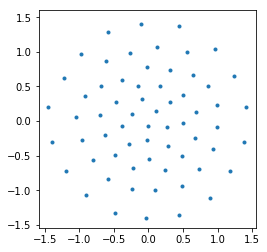

In [11]:
latestConstellation = sess.run(enc_seed_norm, feed_dict=feedDict)
plt.plot(latestConstellation[:,0],latestConstellation[:,1],'.')
plt.axis('square');

In [12]:
if trainingParam.saveWeights:
    if not os.path.exists(trainingParam.path):
        os.makedirs(trainingParam.path)
    myVars = {re.sub(r'\/|\:\d','',x.name):x.eval(session=sess) for x in tf.trainable_variables()}
    fName = 'NNvars_{}'.format(trainingParam.filename)
    scipy.io.savemat(os.path.join(trainingParam.path,fName), myVars)